- [Training](#Training)

# Training

In [1]:
import os
from PIL import Image

import numpy as np
import pandas as pd

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.models import resnet18

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## Hyperparameters

In [2]:
CROP_SIZE = 256
IMAGE_SIZE = 224

BATCH_SIZE = 256

LR = 0.0001
EPOCHS = 10

In [3]:
# Reading the Datafarme
data = pd.read_csv('./dataset/train_challenge.csv')
data.head()

,0,1
0,0.jpg,Adhered
1,1.jpg,Adhered
2,2.jpg,Concrete
3,3.jpg,Concrete
4,4.jpg,Plastic & fabric


In [4]:
# Setup Classes
CLASSES = ['Adhered', 'Ballasted', 'Concrete', 'Plastic & fabric', 'Shingle', 'Steel']

classes_to_idx = {cls: idx for idx, cls in enumerate(CLASSES)}
idx_to_classes = {idx: cls for idx, cls in enumerate(CLASSES)}

In [5]:
# replace '1' column with classes_to_idx dict
data = data.replace({'1': classes_to_idx})
data.head()

,0,1
0,0.jpg,0
1,1.jpg,0
2,2.jpg,2
3,3.jpg,2
4,4.jpg,3


In [6]:
# Make X and Y from dataframe
X = data['0'].values
Y = data['1'].values

In [7]:
# Split into train, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

print(f"Train size: {len(X_train)}\nValidation size: {len(X_val)}\nTest size: {len(X_test)}")

Train size: 6223
Validation size: 692
Test size: 1729


## Torch Dataset and Dataloader

In [8]:
class SatelliteDataset(Dataset):
    def __init__(self, dataroot: str, X_array: np.array, Y_array: np.array, transform = None, target_transform = None):
        self.dataroot = dataroot
        self.X_array = X_array
        self.Y_array = Y_array
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        file_name = self.X_array[index]
        img = Image.open(os.path.join(self.dataroot, file_name)).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
            
        label = np.array(self.Y_array[index])
        if self.target_transform is not None:
            label = self.target_transform(label)
        else:
            label = torch.from_numpy(label)

        return {'image': img, 'label': label, 'image_name': file_name}

    def __len__(self):
        return len(self.X_array)

### Datasets

In [21]:
train_dataset = SatelliteDataset(dataroot='./dataset/train/', X_array=X_train, Y_array=y_train, 
                                 transform=transforms.Compose([transforms.Resize(CROP_SIZE),
                                                               transforms.RandomHorizontalFlip(),
                                                               transforms.CenterCrop(IMAGE_SIZE),
                                                               transforms.ToTensor(),
                                                               transforms.Normalize([0.4728, 0.4762, 0.4692],
                                                                                    [0.2558, 0.2532, 0.2457])]))

val_dataset = SatelliteDataset(dataroot='./dataset/train/', X_array=X_train, Y_array=y_train, 
                               transform=transforms.Compose([transforms.Resize(CROP_SIZE),
                                                             transforms.CenterCrop(IMAGE_SIZE),
                                                             transforms.ToTensor(),
                                                             transforms.Normalize([0.4728, 0.4762, 0.4692],
                                                                                  [0.2558, 0.2532, 0.2457])]))

test_dataset = SatelliteDataset(dataroot='./dataset/train/', X_array=X_train, Y_array=y_train, 
                                transform=transforms.Compose([transforms.Resize(CROP_SIZE),
                                                              transforms.CenterCrop(IMAGE_SIZE),
                                                              transforms.ToTensor(),
                                                              transforms.Normalize([0.4728, 0.4762, 0.4692],
                                                                                   [0.2558, 0.2532, 0.2457])]))

### Dataloaders

In [22]:
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## CUDA

In [11]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
if torch.cuda.is_available():
    print(f"Using {torch.cuda.get_device_name()} for Training")
else:
    print("Using CPU for Training")

Using Tesla T4 for Training


## Models

In [12]:
class ResnetModel(nn.Module):
    def __init__(self):
        super(ResnetModel, self).__init__()
        r = resnet18(pretrained=True)
        fc = nn.Linear(r.fc.in_features, len(CLASSES))
        r.fc = fc
        self.model = r
        
    def forward(self, x):
        x = self.model(x)
        x = F.log_softmax(x, dim=1)
        return x

In [13]:
model = ResnetModel()
model = model.to(device)
model

ResnetModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

## Loss and Optimizer

In [14]:
# Loss
criterion = nn.NLLLoss().cuda() if torch.cuda.is_available() else nn.NLLLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)

## LR scheduler

In [15]:
scheduler = None

## Training

In [16]:
train_losses = []
test_losses = []
accuracies = []

for epoch in range(1, EPOCHS + 1):
    #Training
    train_loss = 0.0
    test_loss = 0.0
    accuracy = 0.0
    
    model.train()
    for data in trainloader:
        x = data['image'].to(device)
        y = data['label'].to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
    
    model.eval()
    with torch.no_grad():
        for data in valloader:
            x = data['image'].to(device)
            y = data['label'].to(device)
            out = model(x)
            loss = criterion(out, y)
            test_loss += loss.item() * x.size(0)
            accuracy += accuracy_score(y.cpu().numpy(), torch.exp(out).argmax(1).cpu().numpy()) * x.size(0)
        
    train_loss /= len(trainloader.dataset)
    test_loss /= len(valloader.dataset)
    accuracy /= len(valloader.dataset)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    
    if scheduler is None:
        print("No Schedular found. LR will not change")
    else:
        if isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
            scheduler.step(test_loss)
        else:
            scheduler.step()
        
    print(f"[Epoch: {epoch}/{EPOCHS}] training loss: {train_loss} validation loss: {test_loss}, accuracy: {accuracy}")
    
print("End of training!!")

No Schedular found. LR will not change
[Epoch: 1/10] training loss: 0.964156989889974 validation loss: 0.7118075203324713, accuracy: 0.7467459424714767
No Schedular found. LR will not change
[Epoch: 2/10] training loss: 0.4416813090091615 validation loss: 0.5625289552908666, accuracy: 0.7890085167925438
No Schedular found. LR will not change
[Epoch: 3/10] training loss: 0.29213374663966274 validation loss: 0.5110841377858427, accuracy: 0.8082918206652739
No Schedular found. LR will not change
[Epoch: 4/10] training loss: 0.20747080443373989 validation loss: 0.5153097602958256, accuracy: 0.8134340350313354
No Schedular found. LR will not change
[Epoch: 5/10] training loss: 0.13573645930973716 validation loss: 0.44300099499026774, accuracy: 0.8407520488510365
No Schedular found. LR will not change
[Epoch: 6/10] training loss: 0.09552771853477304 validation loss: 0.4711552777848557, accuracy: 0.8288606781295196
No Schedular found. LR will not change
[Epoch: 7/10] training loss: 0.07311458

### Training Stats

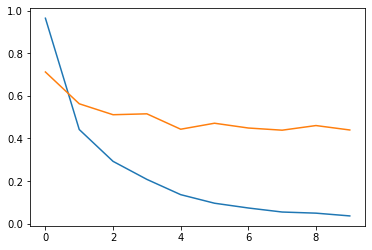

In [17]:
plt.plot(train_losses)
plt.plot(test_losses)

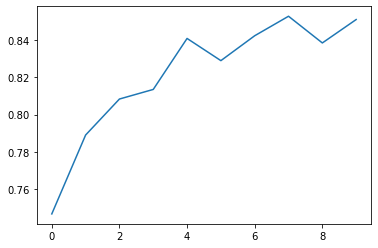

In [18]:
plt.plot(accuracies)

# Testing on training data

In [23]:
y_true = np.empty(0)
y_pred = np.empty(0)

model.eval()
with torch.no_grad():
    for data in testloader:
        x = data['image'].to(device)
        y = data['label'].to(device)
        out = model(x)
        out = torch.exp(out).argmax(1)
        y_true = np.append(y_true, y.cpu().numpy())
        y_pred = np.append(y_pred, out.cpu().numpy())

In [24]:
print(classification_report(y_true, y_pred, target_names=CLASSES))

                  precision    recall  f1-score   support

         Adhered       0.99      0.99      0.99      1671
       Ballasted       0.97      0.99      0.98       537
        Concrete       0.99      1.00      1.00       846
Plastic & fabric       1.00      1.00      1.00       749
         Shingle       1.00      1.00      1.00       751
           Steel       1.00      1.00      1.00      1669

        accuracy                           0.99      6223
       macro avg       0.99      0.99      0.99      6223
    weighted avg       0.99      0.99      0.99      6223



# Testing

In [25]:
# Reading the Datafarme
test_data = pd.read_csv('./dataset/test_challenge.csv')
test_data = test_data.replace({'1': classes_to_idx})
test_data.head()

,0,1
0,0.jpg,0
1,1.jpg,0
2,2.jpg,0
3,3.jpg,0
4,4.jpg,0


In [26]:
testset = SatelliteDataset(dataroot='./dataset/test/', X_array=test_data['0'].values, Y_array=test_data['1'].values, 
                                transform=transforms.Compose([transforms.Resize(CROP_SIZE),
                                                              transforms.CenterCrop(IMAGE_SIZE),
                                                              transforms.ToTensor(),
                                                              transforms.Normalize([0.4728, 0.4762, 0.4692],
                                                                                   [0.2558, 0.2532, 0.2457])]))

In [27]:
testsetloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

In [28]:
len(testsetloader.dataset)

596

In [29]:
y_test_pred = np.empty(0)

model.eval()
with torch.no_grad():
    for data in testsetloader:
        x = data['image'].to(device)
        out = model(x)
        out = torch.exp(out).argmax(1)
        y_test_pred = np.append(y_test_pred, out.cpu().numpy())

In [30]:
y_test_pred.shape

(596,)

In [31]:
d = {'0': test_data['0'].values, '1': y_test_pred.astype(int)}
pd.DataFrame(d).replace({'1': idx_to_classes}).to_csv('./output.csv', index=False)